# **Predictive Analysis with Random Forest**

### Stage 3 - Notebook Summary

- **Intro**: Overview of the project and data source.
- **Setup**: Import libraries, load data, and handle randomness.
- **Data Preview**: Quick look at the dataset.
- **Feature Keys**: Meaning of feature abbreviations.
- **Hypothesis**: Main idea to test with the model.
- **Variable Selection**: Define input and target features.
- **Data Split**: Separate data into training and test sets.
- **Feature Selection**: Use RFE with cross-validation.
- **Tuning**: Optimize Random Forest hyperparameters.
- **Model Training**: Train and validate on training data.
- **Testing**: Final check on test data.
- **Conclusion**: Key outcomes and insights.

### Import essential libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn import feature_selection as fs
import numpy.random as nr

In [2]:
# import the cleaned dataset from a csv file
data = pd.read_csv(r'data_cleaned.csv')
data.head()

,country,year,cereal_yield,fdi_perc_gdp,en_per_gdp,en_per_cap,co2_ttl,co2_per_cap,co2_per_gdp,pop_urb_aggl_perc,prot_area_perc,gdp,gni_per_cap,under_5_mort_rate,pop_growth_perc,pop,urb_pop_growth_perc,urb_pop
0,AGO,1991,417.4,5.449515,179.271884,565.451027,4367.397,0.409949,129.971142,15.290728,12.399822,1.219375e+10,820.0,239.1,3.034866,10653515.0,6.687032,4.099473e+06
1,ARE,1991,1594.0,0.076475,245.977706,12262.388130,57010.849,29.851550,598.807980,26.377204,0.266886,3.391964e+10,19340.0,20.5,5.442852,1909812.0,5.265704,1.507988e+06
2,ARG,1991,2666.1,1.285579,173.122857,1434.960601,117021.304,3.536073,426.614517,39.119646,4.772468,1.897200e+11,3960.0,25.8,1.372593,33093579.0,1.762636,2.890393e+07
3,AUS,1991,1603.3,1.306912,208.686644,4926.727783,281530.258,16.288490,689.948873,60.356798,7.915273,3.299655e+11,18380.0,8.6,1.274577,17284000.0,1.438378,1.478473e+07
4,AUT,1991,5463.0,0.209142,128.939160,3381.073790,65888.656,8.448456,322.186648,19.746121,20.991143,1.721664e+11,21200.0,8.9,1.134999,7798899.0,1.134999,5.131676e+06


### Handling Randomness

To ensure repeatable results, randomness in steps like splitting data, cross-validation, and training the Random Forest is controlled by setting `random_state` and fixing the seed using `numpy.random.seed()`.


In [26]:
# define a random state number for all random state - ensures reproducibility of all results
random_state_num = 0

***

### Overview of the available data
A global overview of the imported data yields the following insights:

In [4]:
print("Shape of the dataset:")
data.shape

Shape of the dataset:


(1700, 18)

In [5]:
print("available columns and their data types:")
data.dtypes

available columns and their data types:


,0
country,object
year,int64
cereal_yield,float64
fdi_perc_gdp,float64
en_per_gdp,float64
en_per_cap,float64
co2_ttl,float64
co2_per_cap,float64
co2_per_gdp,float64
pop_urb_aggl_perc,float64


### Dealing with outliers

A consistent group of outliers—mostly separate from the main data cluster—was identified, primarily belonging to the United Arab Emirates (ARE). To improve model clarity and interpretability, these outliers will be excluded from further analysis.


In [6]:
# remove the ARE outliers
data = data[data['country']!='ARE']

# print shape after removing the outliers
print("Shape of the dataset after removing the ARE outliers:")
data.shape

Shape of the dataset after removing the ARE outliers:


(1686, 18)

### Hypothesis

CO₂ emissions are likely shaped by country-level indicators such as energy use, GDP, population stats, and cereal yield. The hypothesis is that these variables can help predict CO₂ emissions.

### Variable Selection

- **Target (Dependent) Variable**  
  `co2_percap`: CO₂ emissions per capita (metric tons)

- **Features (Independent Variables)**  
  - `cereal_yield`: Cereal yield (kg per hectare)  
  - `fdi_perc_gdp`: FDI inflows (% of GDP)  
  - `gni_per_cap`: GNI per capita (Atlas)  
  - `en_per_cap`: Energy use per capita (kg oil equivalent)  
  - `pop_urb_aggl_perc`: Urban population >1M (%)  
  - `prot_area_perc`: Protected land area (%)  
  - `gdp`: Gross Domestic Product ($)  
  - `pop_growth_perc`: Annual population growth (%)  
  - `urb_pop_growth_perc`: Urban population growth (%)  

These are organized into input features and a target label, then converted into NumPy arrays for model training. The target is referred to as `label` or `labels` in code.

In [27]:
# choose features and label columns
feature_cols = ['cereal_yield','fdi_perc_gdp','gni_per_cap', 'en_per_cap',
                'pop_urb_aggl_perc', 'prot_area_perc', 'pop_growth_perc', 'urb_pop_growth_perc']
label_col = ['co2_per_cap']

# convert into nympy arrays (required for scikit-learn models)
features = np.array(data[feature_cols])
labels =  np.array(data[label_col])

In [28]:
features

array([[4.17400000e+02, 5.44951458e+00, 8.20000000e+02, ...,
        1.23998220e+01, 3.03486601e+00, 6.68703163e+00],
       [2.66610000e+03, 1.28557882e+00, 3.96000000e+03, ...,
        4.77246763e+00, 1.37259322e+00, 1.76263616e+00],
       [1.60330000e+03, 1.30691206e+00, 1.83800000e+04, ...,
        7.91527300e+00, 1.27457750e+00, 1.43837778e+00],
       ...,
       [4.05530000e+03, 3.50366162e+00, 5.86000000e+03, ...,
        6.85955008e+00, 1.10405722e+00, 1.89744981e+00],
       [7.71500000e+02, 1.47989700e+01, 1.60000000e+02, ...,
        9.98656658e+00, 2.76328559e+00, 4.60583400e+00],
       [2.14400000e+03, 6.41099075e+00, 9.70000000e+02, ...,
        3.59830177e+01, 2.65395608e+00, 3.04999620e+00]])

***

### Train-Test Split and Cross-Validation

To validate the model on unseen data, the dataset is split into training and testing sets with an 80:20 ratio. To improve generalization, cross-validation is applied on the training set for feature selection, hyperparameter tuning, and performance evaluation.

The dataset split is performed in the following code snippet:


In [9]:
# split into training and testing subsets
nr.seed(1)
features_train, features_test, labels_train, labels_test = train_test_split(features,
                                                                            labels,
                                                                            test_size=0.2,
                                                                            random_state=random_state_num)

### Scaling of Features

Algorithms like Linear and Logistic Regression require feature scaling to avoid bias from variables with larger ranges. However, since Random Forest relies on decision trees and not regression coefficients, scaling is not necessary in this case.

---

### Feature Selection with Cross-Validation

Using too many or redundant features can lead to overfitting, reduced model performance, and unnecessary complexity. To address this:

- Irrelevant or weakly predictive features are removed.
- Multicollinearity is reduced by eliminating highly correlated variables.
- Model generalization is improved by selecting only the most relevant features.

Feature selection is performed using `RFECV` from `sklearn.feature_selection`, which applies Recursive Feature Elimination with Cross-Validation (based on R² score) to rank and retain top features. The resulting reduced sets are used for training and testing (`features_train_reduced` and `features_test_reduced`).


In [10]:
# Set folds for cross validation for the feature selection
nr.seed(1)
feature_folds = ms.KFold(n_splits=4, shuffle = True, random_state=random_state_num)

# Define the model
rf_selector = RandomForestRegressor(random_state=random_state_num)

# Define an objects for a model for recursive feature elimination with CV
nr.seed(1)
selector = fs.RFECV(estimator = rf_selector, cv = feature_folds, scoring = 'r2', n_jobs=-1)

selector = selector.fit(features_train, np.ravel(labels_train))

selector.support_
print("Feature ranking after RFECV:")
print(selector.ranking_)

# print the important features
ranks_transform = list(np.transpose(selector.ranking_))
chosen_features = [i for i,j in zip(feature_cols,ranks_transform) if j==1]
print("Chosen important features:")
print(chosen_features)

Feature ranking after RFECV:
[1 2 1 1 1 1 1 1]
Chosen important features:
['cereal_yield', 'gni_per_cap', 'en_per_cap', 'pop_urb_aggl_perc', 'prot_area_perc', 'pop_growth_perc', 'urb_pop_growth_perc']


According to the feature rankings, the important parameters for this data set (with ranking 1) are 'cereal_yield', 'en_per_cap', 'pop_urb_aggl_perc', 'prot_area_perc', 'pop_growth_perc'.

Consequently, only these will be kept for the further analysis for both the training and testing dataset (variables *features_train_reduced* and *features_test_reduced*):

In [11]:
# Reduce features
features_train_reduced = selector.transform(features_train)
features_test_reduced = selector.transform(features_test)

print("Training subset shape before the recursive feature elimination: ",features_train.shape)
print("Training subset array shape after the recursive feature elimination: ", features_train_reduced.shape)
print("Test subset array shape after the recursive feature elimination: ",features_test_reduced.shape)

Training subset shape before the recursive feature elimination:  (1348, 8)
Training subset array shape after the recursive feature elimination:  (1348, 7)
Test subset array shape after the recursive feature elimination:  (338, 7)


***

### Hyperparameter tuning

Random Forest is an algorithm with multiple hyperparameters which can have a range of values. In order to find the hyperparameters which would be most suitable for the current data, it is necessary to conduct hyperparameter tuning. The parameters which will be tuned in this case are:

* n_estimators - number of decision trees in the random forest
* max_features - number of features to consider at every split
* max_depth - maximum number of levels in a tree
* min_samples_split - minimum number of samples required to split a node
* min_samples_leaf - minimum number of samples required at each leaf node

The tuning is executed by applying a cross-validated evaluation of the model for different combinations of preliminary defined ranges for the parameters. The output is the model with the hyperparameters which exhibits the best R2 score compared to other parameter combinations.

Define the hyperparameter ranges to be investigated as a parameter grid (dictionary *param_grid*):

In [12]:
# Define value ranges for each hyperparameter
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Keep the rest unchanged
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

# Create the hyperparameter grid
param_grid = {
    'n_estimators': n_estimators,
    'max_features': ['sqrt', 'log2', None] ,
    'max_depth': max_depth,
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

Define the RandomizedSearchCV object, which will evaluate the R2 scores of models with randomly picked combinations from the defined hyperparameter grid:

In [13]:
# define the cross-validation folds for the hyperparameter tuning
nr.seed(1)
inside_folds = ms.KFold(n_splits=5, shuffle = True, random_state=random_state_num)

# Define the random forest regressor model object
rf_tuner = RandomForestRegressor(random_state=random_state_num)

# Perform a randomized search on the grid
nr.seed(1)
rf_model = ms.RandomizedSearchCV(estimator=rf_tuner, param_distributions = param_grid,
                                 random_state=random_state_num, refit=True,
                                 cv=inside_folds, scoring = 'r2', return_train_score=True, n_jobs=-1)

Once fitted to the training data, the `RandomizedSearchCV` will return the best Random Forest model in the best_estimator_ attribute—this model uses the hyperparameter combination that gave the highest R² score during testing.

It's important to note that after finding the best combination, the model is automatically retrained on the full training set (thanks to refit=True in the `RandomizedSearchCV` setup).

Finally, the best hyperparameters are printed.

In [14]:
# Fit the grid search model object with cross-validation on the data
rf_model.fit(features_train_reduced, np.ravel(labels_train))

# Corrected variable name
print("Best Parameters:", rf_model.best_params_)

Best Parameters: {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}


Assign the best model to the model variable *rf_best_model* to be used further:

In [15]:
# pick the model with the best hyperparameter combination for further analysis
rf_best_model = rf_model.best_estimator_

***

### Evaluation of the model with the best hyperparameters on the training subset with cross-validation

The random forest model object *rf_best_model* with the most important features and the most suitable hyperparameters will be now evaluated on the training subset with cross-validation first:

In [16]:
# define the cross-validation folds for the evaluation
nr.seed(1)
outside_folds = ms.KFold(n_splits=10, shuffle = True, random_state=random_state_num)

# Evaluate the model on the training subset with cross-validation
nr.seed(1)
cv_eval = cross_val_score(rf_best_model, features_train_reduced, labels_train, cv = outside_folds, n_jobs=-1)

print('Mean R2 score of all CV folds = %4.3f' % np.mean(cv_eval))
print('Standard deviation of the R2 score over all folds = %4.3f' % np.std(cv_eval))
print('R2 score for each fold:')

# print the R2 score for each fold
for i, j in enumerate(cv_eval):
    print('Fold %2d    %4.3f' % (i+1, j))

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mean R2 score of all CV folds = 0.986
Standard deviation of the R2 score over all folds = 0.004
R2 score for each fold:
Fold  1    0.981
Fold  2    0.979
Fold  3    0.990
Fold  4    0.987
Fold  5    0.985
Fold  6    0.993
Fold  7    0.989
Fold  8    0.982
Fold  9    0.992
Fold 10    0.986


#### Cross-Validation Results

The model achieved strong and consistent performance across all folds:

- **Mean R² score (10 folds):** 0.986  
- **Standard deviation:** 0.004  

While a high R² score (0.968) might initially suggest overfitting, it actually reflects the average across all folds, thanks to cross-validation. The narrow R² range and very low standard deviation (0.004) indicate the model performs consistently and generalizes well across different data splits.


***

### Validate the model on the testing subset

Finally, the model should be validated on previously unseen data, which is the initially separated test subset. The developed model *rf_best_model* is used to predict the CO2 emissions per capita based on the features of the test subset. The quality of the predictions is evaluated by the metrics R2 score, Mean Squared Error and Root Mean Squared Error:

In [17]:
# make predictions from the features of the testing subset
predictions = rf_best_model.predict(features_test_reduced)

# calculate the metrics basing on the predicted and true values for the test subset
r2 = r2_score(y_true=labels_test, y_pred=predictions)
mse = mean_squared_error(y_true=labels_test, y_pred=predictions)
rmse = np.sqrt(mse)

print(f"R2 = {r2}, Mean Squared Error (MSE) = {mse}, Root Mean Squared Error (RMSE) = {rmse}")

R2 = 0.9834303770922288, Mean Squared Error (MSE) = 0.31131625203288366, Root Mean Squared Error (RMSE) = 0.5579572134428263


### Model Evaluation & Prediction Quality

The obtained R² score of **0.986** may seem optimistic at first. However, several steps were taken to reduce overfitting and improve generalization:

- Dataset split with **80% used for training**
- **Cross-validation** during feature selection, hyperparameter tuning, and model training

Note: **MSE and RMSE** values are not directly comparable to the dependent variable (CO₂ per capita), which ranges from **0 to 20 tons**.

To further evaluate performance, a **regression plot** is used to visualize predicted vs. actual CO₂ emissions per capita from the test set.


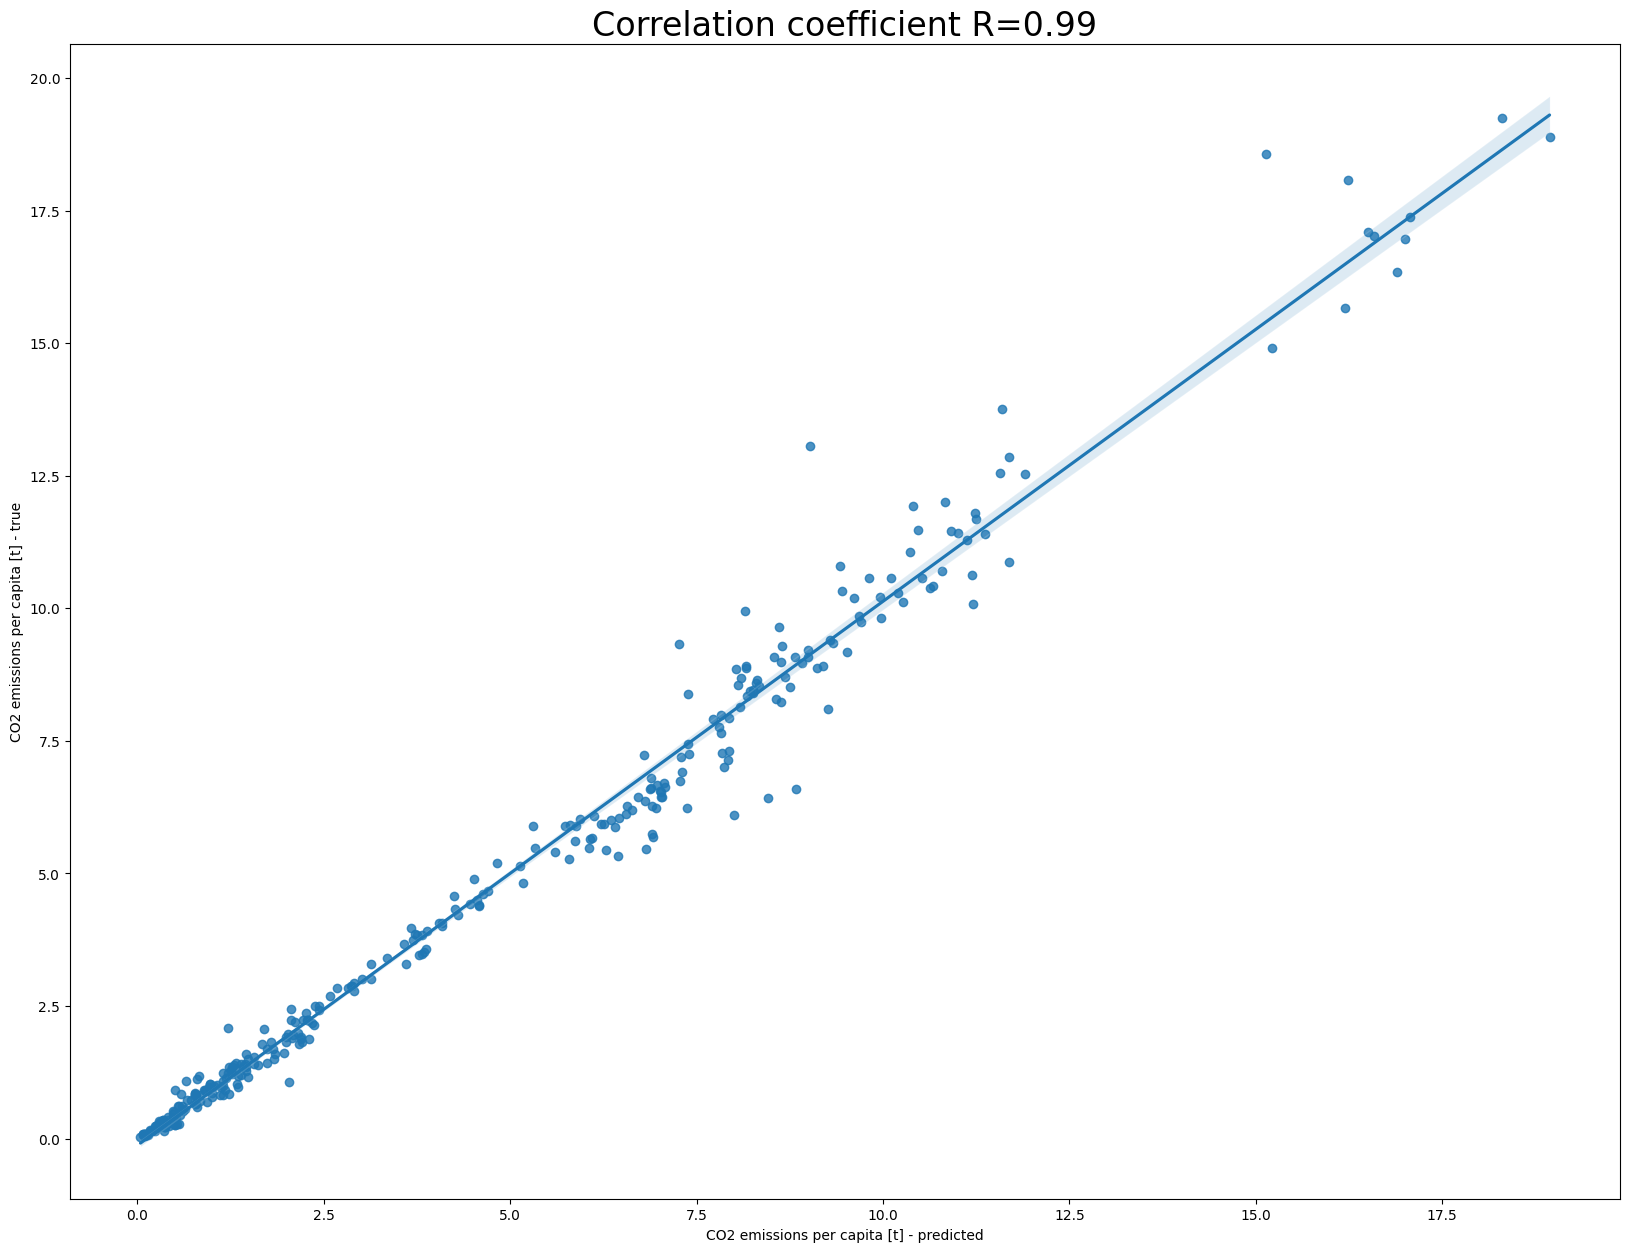

In [18]:
import seaborn as sns
# plot predicted vs true values of the test subset

f,ax=plt.subplots(figsize=(20,15))
sns.set_theme(font_scale=2)

sns.regplot(x=predictions, y=np.transpose(labels_test)[0,:], fit_reg=True)
plt.xlabel("CO2 emissions per capita [t] - predicted")
plt.ylabel("CO2 emissions per capita [t] - true")
plt.title("Correlation coefficient R="+str(round(np.corrcoef(predictions,np.transpose(labels_test)[0,:])[0,1],2)))
plt.show()

The model demonstrates excellent predictive performance for CO₂ emissions per capita.

### Final Model Performance Summary

All key steps were taken to ensure the model generalizes well to unseen data. It achieved a high average **R² score of 0.98** across the cross-validated training set and each fold. Test set predictions also align closely with true values, with the same **R² = 0.98** and no major outliers.

While confidence intervals were not calculated, the large test set size (**1,181 observations**) reinforces the model’s robustness and reliability.

**Conclusion:**  
The model can predict a country’s annual CO₂ emissions per capita with **98.2% R² accuracy**, using key features like:
- Cereal yield  
- Protected land percentage  
- Energy use per capita  
- Urban population percentage  
- Population growth rate


***

In [19]:
import joblib

# Save the trained model to file
joblib.dump(rf_best_model, 'forecasting_co2_emmision.pkl')
print("Model saved to 'forecasting_co2_emmision.pkl")

Model saved to 'forecasting_co2_emmision.pkl


In [20]:
# Load model from file
loaded_model = joblib.load('forecasting_co2_emmision.pkl')
print("📂 Model loaded successfully.")

📂 Model loaded successfully.


### Calculating Compound Annual Growth Rates (CAGR) for Key Features

To assess long-term trends in country-level development indicators, we compute the **Compound Annual Growth Rate (CAGR)** for each of the selected features:

- `cereal_yield`
- `gni_per_cap`
- `en_per_cap`
- `pop_urb_aggl_perc`
- `prot_area_perc`
- `pop_growth_perc`
- `urb_pop_growth_perc`

The process involves:
- Filtering the dataset for a predefined list of selected countries.
- Sorting the data by year for each country.
- Calculating the CAGR for each feature based on its value in the earliest and latest available years.
- Skipping entries where data is missing, invalid, or where the time range is insufficient.

This analysis helps identify whether each feature has increased or decreased over time in each country, offering insights into national trends that may impact CO₂ emissions.

The final output displays feature-wise growth rates (in percentages) for each country in the form:



In [21]:
# List of selected features
selected_features = ['cereal_yield', 'gni_per_cap', 'en_per_cap',
                     'pop_urb_aggl_perc', 'prot_area_perc',
                     'pop_growth_perc', 'urb_pop_growth_perc']


In [22]:
selected_countries = ['IND', 'USA', 'PAK', 'RUS', 'NZL']

# Filter the dataset to include only the selected countries
df_filtered = data[data['country'].isin(selected_countries)]

# Dictionary to store the growth rates for each country
growth_rates = {}

# Loop over each selected country
for country in selected_countries:
    # Get data for the current country and sort it by year
    country_data = data[(data['country'] == country)].sort_values('year')

    # Identify the start and end year for the country
    start_year = country_data['year'].min()
    end_year = country_data['year'].max()
    years = end_year - start_year  # Total number of years between start and end

    # Dictionary to store growth rates of all features for the current country
    country_growth = {}

    # Skip this country if the time span is not valid (e.g., only one year of data)
    if years <= 0:
        print(f"Skipping {country} due to insufficient year range.")
        continue

    # Loop through each selected feature
    for feature in selected_features:
        # Get the feature value in the start year
        start_value = country_data[country_data['year'] == start_year][feature].values
        # Get the feature value in the end year
        end_value = country_data[country_data['year'] == end_year][feature].values

        # Skip if either value is missing
        if len(start_value) == 0 or len(end_value) == 0:
            continue

        # Extract scalar values from arrays
        start_value = start_value[0]
        end_value = end_value[0]

        # Skip if values are non-positive or not finite (e.g., NaN, inf)
        if start_value <= 0 or end_value <= 0 or not np.isfinite(start_value) or not np.isfinite(end_value):
            continue

        # Compute the Compound Annual Growth Rate (CAGR)
        cagr = (end_value / start_value) ** (1 / years) - 1
        # Store the result in the country-specific dictionary
        country_growth[feature] = cagr

    # Save the growth rates of all features for the current country
    growth_rates[country] = country_growth

In [23]:
# Display the calculated growth rates in a readable format
print("\nGrowth Rates (CAGR) from {} to {}:\n".format(start_year, end_year))

# Loop through each country and its corresponding growth rate dictionary
for country, features in growth_rates.items():
    print(f"{country}")  # Print the country name with an icon

    # Loop through each feature and its CAGR value
    for feature, rate in features.items():
        # Determine whether to display a plus or minus sign
        sign = '+' if rate >= 0 else '−'

        # Print the feature name and its growth rate percentage (formatted to two decimal places)
        print(f"  • {feature}: {sign}{abs(rate * 100):.2f}%")

    # Add a line break between countries for readability
    print()


Growth Rates (CAGR) from 1991 to 2008:

IND
  • cereal_yield: +1.94%
  • gni_per_cap: +6.85%
  • en_per_cap: +2.12%
  • pop_urb_aggl_perc: +1.26%
  • prot_area_perc: +0.35%
  • pop_growth_perc: −2.28%
  • urb_pop_growth_perc: −1.26%

USA
  • cereal_yield: +2.28%
  • gni_per_cap: +4.26%
  • en_per_cap: −0.12%
  • pop_urb_aggl_perc: +0.40%
  • prot_area_perc: +0.01%
  • pop_growth_perc: −2.16%
  • urb_pop_growth_perc: −2.15%

PAK
  • cereal_yield: +2.29%
  • gni_per_cap: +5.00%
  • en_per_cap: +1.50%
  • pop_urb_aggl_perc: +0.84%
  • prot_area_perc: +0.01%
  • pop_growth_perc: −2.46%
  • urb_pop_growth_perc: −1.01%

RUS
  • cereal_yield: +1.99%
  • gni_per_cap: +7.41%
  • en_per_cap: −0.61%
  • pop_urb_aggl_perc: +0.48%
  • prot_area_perc: +0.46%

NZL
  • cereal_yield: +1.96%
  • gni_per_cap: +5.00%
  • en_per_cap: +0.39%
  • pop_urb_aggl_perc: +1.15%
  • prot_area_perc: +0.17%
  • pop_growth_perc: −2.04%
  • urb_pop_growth_perc: −1.83%



## 📌 CAGR Analysis (1991–2008)

### Key Insights by Country:

- **Economic Growth**  
  All countries showed GNI per capita growth. Russia (+7.41%), India (+6.85%), and Pakistan/New Zealand (+5.00%) led the way, highlighting strong economic progress.

- **Agriculture**  
  Cereal yields rose in all cases, led by Pakistan (+2.29%) and the USA (+2.28%), pointing to steady improvements in farming methods.

- **Energy Use**  
  India and Pakistan reported rising per capita energy use. In contrast, Russia (−0.61%) and the USA (−0.12%) saw slight drops—possibly due to efficiency gains or industrial shifts.

- **Urbanization**  
  Urban population percentages grew moderately, while overall and urban population growth rates declined—suggesting slower population expansion and urban migration.

- **Protected Land Areas**  
  Slight gains in land protection were seen, especially in Russia (+0.46%) and India (+0.35%), indicating slow progress in conservation.

**Summary**:  
The data reflects growth in economy and agriculture, mixed energy trends, urban transition, and modest environmental protection. Population metrics hint at demographic shifts ahead.

---

## 🔮 Forecasting CO₂ Emissions per Capita (Next 20 Years)

This section uses the trained Random Forest model to estimate CO₂ emissions per capita through these steps:

1. **Timeline Setup**  
   Forecast extends 20 years beyond the dataset's latest entry.

2. **Base Year Reference**  
   The most recent data row is pulled per country.

3. **Feature Growth Simulation**  
   Each feature is grown yearly using its historical CAGR.

4. **CO₂ Prediction**  
   The model predicts emissions based on yearly updated features.

5. **Results & Visualization**  
   Forecasted values are stored, plotted, and displayed. A table shows India’s last 5 predicted years for reference.

In [24]:
# Define the range of years to forecast (next 20 years beyond the last available year)
last_year = data['year'].max()
future_years = list(range(last_year + 1, last_year + 21))

In [25]:
# Initialize a list to store forecasted results
forecast_results = []

# Loop through each selected country for prediction
for country in selected_countries:
    country_data = data[(data['country'] == country)].sort_values('year')

    # Skip countries with missing feature values
    if country_data[selected_features].dropna().empty:
        print(f"Skipping {country} due to missing values.")
        continue

    # Take the latest complete record (most recent year) for the country
    latest_row = country_data[selected_features].dropna().iloc[-1].copy()

    # Forecast for each year into the future
    for year in future_years:
        # Apply the previously calculated CAGR to each feature
        for feature in selected_features:
            growth_rate = growth_rates.get(country, {}).get(feature, 0.0)
            latest_row[feature] *= (1 + growth_rate)

        # Use trained model to predict CO₂ emissions per capita
        input_features = latest_row.values.reshape(1, -1)
        predicted_co2 = loaded_model.predict(input_features)[0]

        # Store the forecast result
        forecast_results.append({
            'country': country,
            'year': year,
            'co2_percap': predicted_co2
        })

📈 Forecasted CO₂ Emissions per Capita (Next 20 Years)


/var/folders/tx/wk7wgjjj50l10ddtt3kczpnh0000gn/T/ipykernel_38012/4163859294.py:13: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


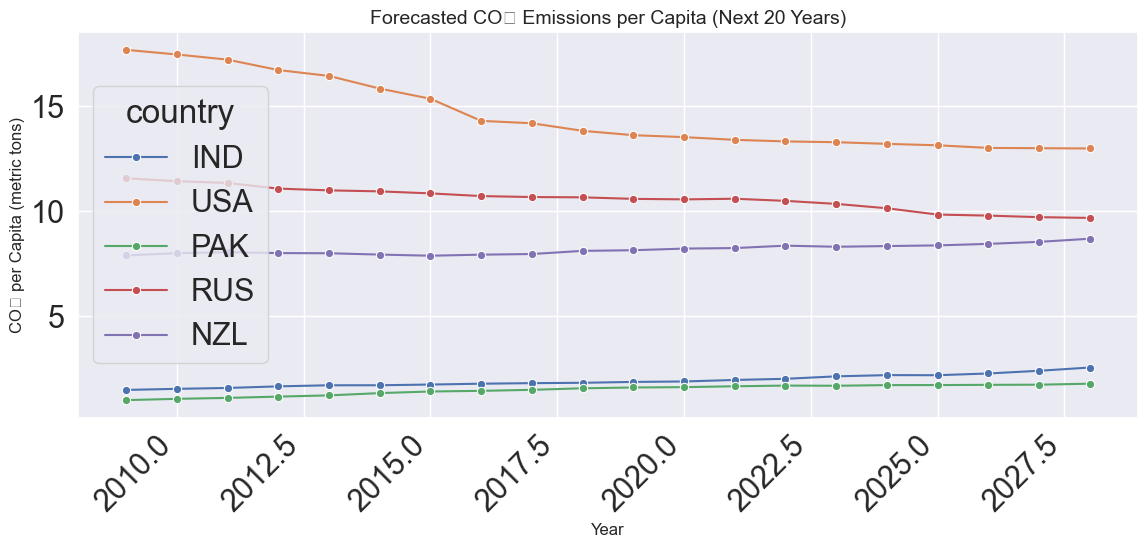


📊 Forecasted CO₂ per Capita for Last 5 Years in Forecast Period (India):

   country  year  co2_percap
15     IND  2024    2.194019
16     IND  2025    2.190429
17     IND  2026    2.272474
18     IND  2027    2.401276
19     IND  2028    2.555614


In [ ]:
# Convert the list of predictions into a DataFrame
df_forecast = pd.DataFrame(forecast_results)

# Plot forecasted CO₂ per capita for all countries over the next 20 years
print('📈 Forecasted CO₂ Emissions per Capita (Next 20 Years)')
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_forecast, x='year', y='co2_percap', hue='country', marker='o')
plt.title('Forecasted CO₂ Emissions per Capita (Next 20 Years)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('CO₂ per Capita (metric tons)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

# Print the forecast values for the last 5 years for India
print("\n📊 Forecasted CO₂ per Capita for Last 5 Years in Forecast Period (India):\n")
print(df_forecast[df_forecast['country'] == 'IND'].sort_values(by='year').tail(5))

## 📊 CO₂ Emissions Forecast – Country Comparison (Next 20 Years)

This plot shows projected CO₂ emissions per capita for five countries: **USA, Russia (RUS), New Zealand (NZL), India (IND), and Pakistan (PAK)**.

### 🔍 Highlights:

- **USA**:  
  Starts highest (~17 metric tons) and declines steadily, but remains the top emitter per person.

- **Russia**:  
  Emissions stay mostly flat with a mild decrease — hinting at modest change.

- **New Zealand**:  
  Shows a slow rise, possibly linked to increased industrial or transport activity.

- **India & Pakistan**:  
  Start low (~1.5–2 metric tons) but gradually rise, reflecting growing energy use tied to economic development.

### 🌍 Global Pattern:

Developed nations (USA, RUS) show declining trends — likely due to cleaner tech and energy policies.  
Developing countries (IND, PAK) are on a growth path — indicating industrial progress and rising demand.  

**Conclusion**:  
Emissions patterns are converging globally, but at different rates and starting points.